# 项目：欧洲顶级足球联赛冠军竞争程度分析

## 目录
<ul>
<li><a href="#intro">简介</a></li>
<li><a href="#wrangling">数据整理</a></li>
<li><a href="#eda">探索性数据分析</a></li>
<li><a href="#conclusions">结论</a></li>
</ul>

<a id='intro'></a>
## 简介
[数据源自kaggle，点击此链接获取kaggle上对此数据的详细解释。](https://www.kaggle.com/hugomathien/soccer) 数据集中的信息包含欧洲11个国家的顶级联赛在2008到2016赛季中的球队、球员和比赛信息。本报告将利用这些信息分析这些联赛中球队的表现，以及联赛中球队的竞争激烈程度。


In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
% matplotlib inline

<a id='wrangling'></a>
## 数据整理

### 常规属性
首先与数据库建立连接。

In [2]:
# 查看数据库中有哪些表
con = sqlite3.connect('database.sqlite')
sql = 'SELECT * FROM sqlite_master WHERE type="table" ORDER BY name '
tabs = pd.read_sql_query(sql,con)
tabs

,type,name,tbl_name,rootpage,sql
0,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
1,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
2,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
3,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
4,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
5,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
6,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...
7,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"


数据库中总共有8个表，包含国家、联赛、比赛、球员、球队等数据。

In [3]:
#查看联赛表的数据
sql = 'SELECT * FROM League'
df_league = pd.read_sql_query(sql,con) 
df_league

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


In [4]:
# 查看Match表的大小
sql = 'SELECT * FROM Match'
df_match = pd.read_sql_query(sql,con) 
print(df_match.shape)

(25979, 115)


## 数据完整度

In [5]:
print(sum(df_match.duplicated()))
print(sum(df_match.isnull().sum(axis=1)>0))

0
24217


在Match表的25979行中，有24217行存在数据缺失，我们需要确定缺失的数据主要出现在哪些列中。

In [6]:
df_match.count()

id                  25979
country_id          25979
league_id           25979
season              25979
stage               25979
date                25979
match_api_id        25979
home_team_api_id    25979
away_team_api_id    25979
home_team_goal      25979
away_team_goal      25979
home_player_X1      24158
home_player_X2      24158
home_player_X3      24147
home_player_X4      24147
home_player_X5      24147
home_player_X6      24147
home_player_X7      24147
home_player_X8      24147
home_player_X9      24147
home_player_X10     24147
home_player_X11     24147
away_player_X1      24147
away_player_X2      24147
away_player_X3      24147
away_player_X4      24147
away_player_X5      24147
away_player_X6      24147
away_player_X7      24147
away_player_X8      24147
                    ...  
B365H               22592
B365D               22592
B365A               22592
BWH                 22575
BWD                 22575
BWA                 22575
IWH                 22520
IWD         

'Match'表中缺失的数据主要集中在球员位置信息和博彩公司数据中，前11行与比赛结果相关的数据不存在缺失情况。

### 获取各只队伍比赛积分数据

#### 在足球的联赛中，比赛积分是衡量球队表现的主要指标，每个赛季结束后，大部分联赛中积分最高的球队获得其所在联赛的相应赛季冠军。但也有少数联赛采用季后赛淘汰制选拔冠军球队。这里我们取公认的五大联作为研究对象，即英格兰超级联赛、德国足球甲级联赛、西班牙足球甲级联赛、法国足球甲级联赛、意大利足球甲级联赛（简称英超、德甲、西甲、法甲、意甲）。'Match'表中没有比赛的积分数据，因此在下面需要通过主、客队的比赛进球数来获取比赛积分数据。

需要先验证联赛内比赛数据的完整性，欧洲五大联赛比赛都是每支队伍和联赛内其余队伍在主、客场各进行一次比赛，除了德甲有18支队伍外，其它4个联赛都有20支队伍，比赛总场次分别是：17x18=306,19x20=380。

In [7]:
#获取数据集中各支联赛在每个赛季中的比赛总场次
sql = '''SELECT l.name league, season, COUNT(*) total_matchs
FROM Match m 
JOIN League l ON m.league_id = l.id 
WHERE league IN ("England Premier League","Germany 1. Bundesliga","Spain LIGA BBVA","France Ligue 1","Italy Serie A")
GROUP BY league_id,season'''
df_matchs = pd.read_sql_query(sql,con)
df_matchs

,league,season,total_matchs
0,England Premier League,2008/2009,380
1,England Premier League,2009/2010,380
2,England Premier League,2010/2011,380
3,England Premier League,2011/2012,380
4,England Premier League,2012/2013,380
5,England Premier League,2013/2014,380
6,England Premier League,2014/2015,380
7,England Premier League,2015/2016,380
8,France Ligue 1,2008/2009,380
9,France Ligue 1,2009/2010,380


由此可见Italy Serie A联赛中在2011/2012和2014/2015两个赛季中比赛场次存在缺失。由于联赛积分排名对每场比赛结果都有依赖，因此接下来我们不再考虑这个联赛的数据。
接下来我们获取其他4支联赛的比赛数据。

In [8]:
# 获取2008-2016赛季各个球队的主场比赛数据
sql = '''WITH t1 AS ( 
SELECT l.name AS league, season,stage,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal, 
tm1.team_long_name AS home_team_name, 
tm2.team_long_name AS away_team_name,
CASE 
WHEN m.home_team_goal > m.away_team_goal THEN 3 
WHEN m.home_team_goal == m.away_team_goal THEN 1 
WHEN m.home_team_goal < m.away_team_goal THEN 0 END AS home_team_points, 
CASE 
WHEN m.home_team_goal > m.away_team_goal THEN 0 
WHEN m.home_team_goal == m.away_team_goal THEN 1 
WHEN m.home_team_goal < m.away_team_goal THEN 3 END AS away_team_points 
FROM Match m 
JOIN League l 
ON m.league_id = l.id 
JOIN Team tm1 
ON m.home_team_api_id = tm1.team_api_id 
JOIN Team tm2 
ON m.away_team_api_id = tm2.team_api_id) 
SELECT season,league,home_team_name AS team_name,SUM(home_team_points) AS home_points, 
SUM(home_team_goal) AS home_goals_for, SUM(away_team_goal) AS home_goals_aga 
FROM t1 
WHERE league IN ("England Premier League","Germany 1. Bundesliga","Spain LIGA BBVA","France Ligue 1") 
GROUP BY 1,2,3 
ORDER BY 1 DESC,2, 3 DESC'''
df_home_points = pd.read_sql_query(sql,con)
df_home_points.shape

(624, 6)

In [9]:
# 获取2008-2016赛季各个球队的客场比赛数据
sql = '''WITH t1 AS (
SELECT season,l.name AS league,stage,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal, 
tm1.team_long_name AS home_team_name, 
tm2.team_long_name AS away_team_name, 
CASE 
WHEN m.home_team_goal > m.away_team_goal THEN 3 
WHEN m.home_team_goal == m.away_team_goal THEN 1 
WHEN m.home_team_goal < m.away_team_goal THEN 0 END AS home_team_points, 
CASE 
WHEN m.home_team_goal > m.away_team_goal THEN 0 
WHEN m.home_team_goal == m.away_team_goal THEN 1 
WHEN m.home_team_goal < m.away_team_goal THEN 3 END AS away_team_points 
FROM Match m 
JOIN League l 
ON m.league_id = l.id 
JOIN Team tm1 
ON m.home_team_api_id = tm1.team_api_id 
JOIN Team tm2 
ON m.away_team_api_id = tm2.team_api_id) 
SELECT season,league,away_team_name AS team_name,SUM(away_team_points) AS away_points, 
SUM(away_team_goal) AS away_goals_for, SUM(home_team_goal) AS away_goals_aga 
FROM t1 
WHERE league IN ("England Premier League","Germany 1. Bundesliga","Spain LIGA BBVA","France Ligue 1") 
GROUP BY 1,2,3 
ORDER BY 1 DESC,2,3 DESC'''
df_away_points = pd.read_sql_query(sql,con)
df_away_points.shape

(624, 6)

以上查询获取了2008至2016这8个赛季中各支球队的比赛的主、客场积分，下面我们需要得到每只球队每个赛季的总比分，这需要将每只球队的主、客场积分相加。

In [10]:
#合并主、客场比赛结果数据
df = pd.merge(df_home_points,df_away_points)
#获取每只球队每个赛季的总积分
df['points'] = df['home_points']+df['away_points']
#获取每只队伍的净胜球数据
df['goals_diff'] = df['home_goals_for']+df['away_goals_for']-df['home_goals_aga']-df['away_goals_aga']
df.sort_values(by=['season','league','points','goals_diff'],ascending=False,inplace=True)
df.reset_index(drop=True,inplace=True)
df.head(1)

,season,league,team_name,home_points,home_goals_for,home_goals_aga,away_points,away_goals_for,away_goals_aga,points,goals_diff
0,2015/2016,Spain LIGA BBVA,FC Barcelona,49,67,14,42,45,15,91,83


现在已经获得了每个球队在这8个赛季中的比赛积分和进球数据，并且按照赛季、联赛名称、积分、净胜球数对球队进行了排序。下面我们通过积分排名来获取每个赛季的联赛冠军。事实上，每个联赛在联赛积分相同的情况下，确定冠军归属的方法有所不同，有的联赛是净胜球多的排名靠前，有的是相互比赛成绩好的排名靠前。在这里我们做简化处理，在积分相同时按照净胜球进行排名。

下面的df_champions中存储了每个赛季、每个联赛的联赛冠军球队，以及冠军球队的比赛积分和进球数据。

In [11]:
df_champions = df.groupby(by=['season','league']).head(1).reset_index(drop=True)
df_champions.head()

,season,league,team_name,home_points,home_goals_for,home_goals_aga,away_points,away_goals_for,away_goals_aga,points,goals_diff
0,2015/2016,Spain LIGA BBVA,FC Barcelona,49,67,14,42,45,15,91,83
1,2015/2016,Germany 1. Bundesliga,FC Bayern Munich,46,51,8,42,29,9,88,63
2,2015/2016,France Ligue 1,Paris Saint-Germain,48,59,12,48,43,7,96,83
3,2015/2016,England Premier League,Leicester City,42,35,18,39,33,18,81,32
4,2014/2015,Spain LIGA BBVA,FC Barcelona,49,64,11,45,46,10,94,89


<a id='eda'></a>
## 探索性数据分析

### 研究问题 1 哪支球队在这段时间内的表现最好？

由于比赛数据中只包含联赛内部球队的比赛数据，不包含不同联赛之间球队的比赛数据，因此，我们只能评判球队在各自联赛内的表现。这里采用的指标是球队获得联赛冠军的次数。

In [12]:
df_champions['team_name'].nunique()

15

有15只队伍获得了这段时间中的8个赛季、4种联赛的32个冠军，现在需要查看获取冠军次数最多的是哪几只球队。

In [13]:
df2 = df_champions.groupby(['league','team_name'])['season'].count().reset_index(name='cp_count')
df2 = df2.sort_values(by='cp_count',ascending=False).reset_index(drop=True)
df2.head(3)

,league,team_name,cp_count
0,Spain LIGA BBVA,FC Barcelona,6
1,Germany 1. Bundesliga,FC Bayern Munich,5
2,France Ligue 1,Paris Saint-Germain,4


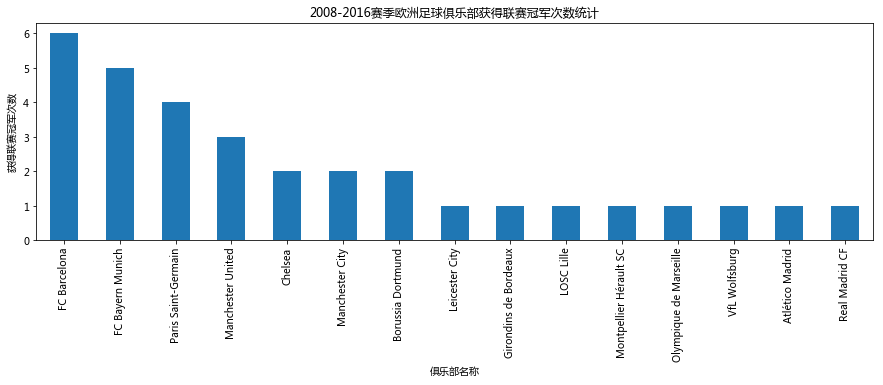

In [14]:
plt.rcParams['font.sans-serif']=['Microsoft YaHei'] #用来正常显示中文标签
df2.plot(kind='bar',x=df2['team_name'],figsize=(15,4),legend=False)
plt.title('2008-2016赛季欧洲足球俱乐部获得联赛冠军次数统计')
plt.xlabel('俱乐部名称');
plt.ylabel('获得联赛冠军次数');

依据获得冠军的次数，在这期间西班牙甲级联赛的巴塞罗那队获得冠军的次数最多，达到6次，其次是德甲的拜仁慕尼黑队，获得了5次联赛冠军。

### 研究问题 2 哪个联赛在这期间球队对联赛冠军的竞争最为激烈？

判断联赛冠军争夺的激烈程度，需要从多个维度去分析数据。这里尝试从获得联赛冠军球队的数量、排名靠前球队的积分差距这两个方面分析各个联赛冠军争夺的激烈程度。

> 首先获取每个联赛获得过联赛冠军的球队数目。一般而言，这个数目越多，联赛中参与冠军争夺的球队越多，竞争就越激烈。

In [15]:
df3 = df_champions.groupby('league')['team_name'].nunique().reset_index(name='teams_get_titles')
df3 = df3.sort_values(by='teams_get_titles',ascending=False).reset_index(drop=True)

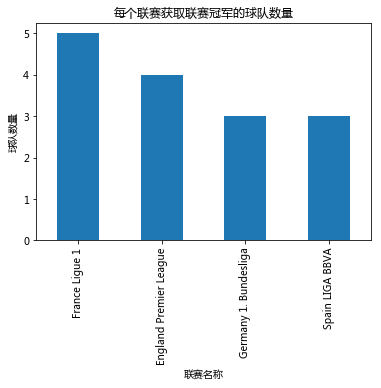

In [16]:
df3.plot(kind='bar',x=df3['league'],legend=False);
plt.title('每个联赛获取联赛冠军的球队数量');
plt.xlabel('联赛名称');
plt.ylabel('球队数量');

在数据集中的这8个赛季，法国足球甲级联赛中得过联赛冠军的队伍最多，达到5支，其次是英格兰足球超级联赛，有4只球队获得过这期间的联赛冠军。

> 接下来获取每个联赛中积分排名靠前球队的积分差距，积分差距越小，联赛冠军竞争就越激烈。这里我们取每个联赛排名前四球队的积分，计算其标准差，标准差越小，则前4支球队的积分越接近，竞争就越激烈。

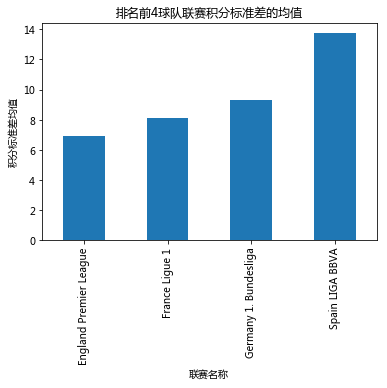

In [17]:
df_top4 = df.groupby(['season','league']).head(4).reset_index(drop=True)
df_pstd = df_top4.groupby(['season','league'])['points'].std().reset_index(name='P_Std')
df_pstd.groupby('league').mean().sort_values('P_Std').plot(kind='bar',legend=False)
plt.title('排名前4球队联赛积分标准差的均值');
plt.xlabel('联赛名称');
plt.ylabel('积分标准差均值');

根据8个赛季中积分标准差的均值，英超联赛的前四球队积分最为接近，其次是法甲联赛。积分差距最大的是西甲联赛。

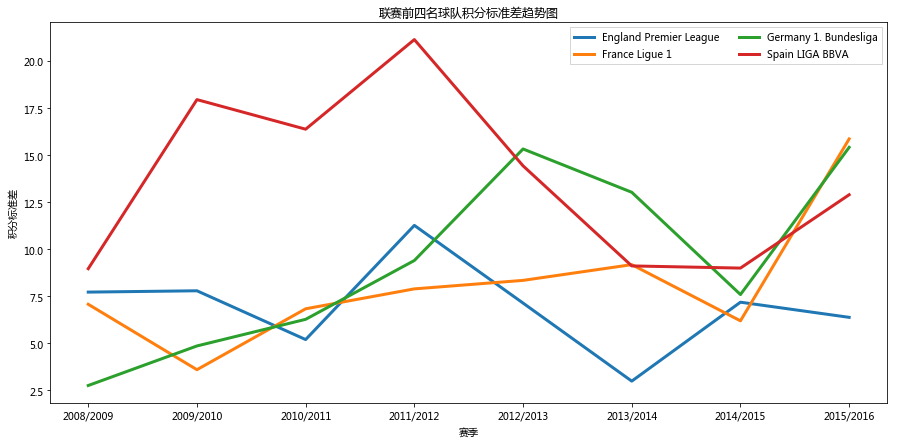

In [18]:
df_pstd.sort_values(by=['league','season'],inplace=True)
plt.figure(figsize=(15,7));
for league in df_pstd['league'].unique():
    plt.plot(df_pstd['season'].unique(),df_pstd.query('league=="{}"'.format(league))['P_Std'],linewidth=3.0,label=league);
plt.title('联赛前四名球队积分标准差趋势图');
plt.xlabel('赛季')
plt.ylabel('积分标准差')
plt.legend(loc='best', ncol=2, shadow=False, fancybox=False);

上图中，2012/2013赛季之前的四个赛季中，西甲联赛的前四球队积分差距明显高于其它联赛，而在之后的4个赛季中有所下降。英超联赛积分差距波动最小，并且有4个赛季是积分差距最小的联赛。

<a id='conclusions'></a>
## 结论

本报告首先对比赛数据进行处理，得到各支队伍的比赛积分信息，在这期间我们剔除了与比赛结果无关的博彩数据、阵容数据等部分内容。在验证联赛比赛数据完整性时发现意甲联赛在两个赛季中存在数据缺失，而联赛排名对每场比赛数据都有依赖，这里不宜做数据清理，因此在后面的问题中没有考虑意甲联赛。

在每个赛季中，对其它4支联赛中球队根据积分和净胜球进行了排名。通过分析球多获得冠军的次数，得出西甲联赛的巴塞罗那球队是这期间表现最好的球队。

在之后的问题中，通过分析联赛中排名靠前球队的积分差距大小来确定联赛中争冠球队的竞争程度，这里采用排名前4球队的积分的标准差做为联赛冠军竞争程度的指标，指标越小，反应联赛中争冠球队越势均力敌，冠军争夺越激烈。最终得出英超联赛的冠军争夺最为激烈。

In [22]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset-zh.ipynb'])

0

### 参考
1. 分析联赛竞争激烈程度的方法多有争论，本报告中采用的分析方法受到了[Which is the most competitive soccer league in Europe?](https://www.pinnacle.com/en/betting-articles/Soccer/which-is-the-most-competitive-league-in-europe/UP62V3FWN49UCT5P)文章的启发。